# Data Component Use Case for Overland Flow Simulation

## Introduction

Overland flow, particularly the infiltration-excess mechanism, is affected by the nature of water input through precipitation. This Jupyter notebook demonstrates how to use the [CSDMS data components](https://csdms.colorado.edu/wiki/DataComponents) to download the topography and precipitation datasets and use the [Landlab](https://landlab.readthedocs.io/en/master/) components to delineate the watershed and simulate the overland flow for a study area in the Boulder County. 

In this notebook, it includes the following sections:
- [Initial Setup](#setup)
  
  This section will help install several Python packages and create the input/output folders.
  <br>
- [Step 1: Download Dataset](#step1) 

  This section will download the topography and the precipitation datasets.
  <br>
- [Step 2: Delineate Watershed](#step2)

  This section will use the topography dataset and landlab components to delineate the watershed for the study area. 
  <br>
- [Step 3: Calculate overland flow](#step3)

  This section will use the watershed topography data and overland flow landlab component to simulate the surface water depth and discharge.
  <br>
- [Step 4: Visualize Results](#step4)

  This section will visualize the final results as a short video.
  <br>


**Suggested Citation:** Gan, T., Tucker, G. E., Overeem, I. (2023). Data Component Use Case for Overland Flow Simulation, HydroShare, https://www.hydroshare.org/resource/bcbcfe823cc4432f8ce96c3048d4591f/


<a id='setup'></a>
## Initial Setup

We will need to install several python packages and create folders for this notebook. After you install the packages, you will need to run a helper function to create API Key files for the Topography and ERA5 data components.

### Install Packages (on Local PC)
If you want to run this notebook on your PC, you can run the following command which will create a separate conda environment named "overlandflow_usecase" and install all the required packages for you. After the installation, please make sure to activate the environment to run this notebook.

In [1]:
# ! conda env create --file=environment.yml

### Install API key files
For the Topography and ERA5 data components, there is a need to create API key files to download the datasets. The install_api_key( ) function will ask for your [CDS API Key](https://cds.climate.copernicus.eu/api-how-to) and [Open Topography API Key](https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets) to create API key files. Please make sure you have already obtained those API Keys before you run this helper function.

In [2]:
from utils import install_api_key
install_api_key()
#opentopography key: 871df3be270da666003f434c3f5f58e5

Enter Your OpenTopography API Key:  871df3be270da666003f434c3f5f58e5


OpenTopography API Key file is created at /home/jupyter-asimps10@uoregon.e-8f45d/SnowFlow/.opentopography.txt.


### Create folders
We will first import all the python packages and then create three folders for this notebook:
- **configuration file folder**: this folder includes a configuration file which will be used by the data component. In this example, we have prepared a configuration file ('dem_config.yaml') and put it in this folder. 
- **cache folder**: this folder stores the downloaded data file.
- **results folder**: this folder stores the final results.

In [3]:
# import packages 
import os
import warnings

import numpy as np
import pandas as pd
import xarray
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio.v2 as imageio
from IPython.display import Video
from tqdm import trange

from pymt.models import Topography, Era5
from landlab import RasterModelGrid, imshow_grid, imshow_grid_at_node, HexModelGrid
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.drainage_plot import drainage_plot
from landlab.utils import get_watershed_mask

from landlab.plot.graph import plot_graph

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 14})

In [4]:
# create folders
study_area = 'calwood'

config_dir = os.path.join(os.getcwd(), 'config_files_{}'.format(study_area))
results_dir = os.path.join(os.getcwd(), 'results_{}'.format(study_area)) 
cache_dir = os.path.join(os.getcwd(),'cache_{}'.format(study_area))


for folder in [config_dir, results_dir, cache_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)
        print(folder)

<a id='step1'></a>
## Step 1 Download Dataset

### OpenTopography DEM 

The number of wildfire increased in the Colorado State in recent years. A destructive wildfire can burn away plants and trees that prevent erosion. If heavy rains occur after such a fire, landslides and flash floods can occur. In this example, we will simulate the overland flow for a study area in the northwest of Boulder which was impacted by the CalWood Fire occurred in 2020. 

We will use the [Topography data component](https://csdms.colorado.edu/wiki/Model:Topography_Data_Component) to download the Digital Elevation Model (DEM) data with 30m resolution. The 'dem_config.yaml' file includes the parameter settings of this data component. The following cells demonstrate how to use the configuration file to initialize a data component and how to use the variable and grid related methods of this data component to get the metadata as well as the data values.

In [5]:
# initialize Topography data component
dem = Topography()
dem.initialize(os.path.join(config_dir, 'dem_config.yaml'))

In [6]:
#H = HexModelGrid((5,5), 10, node_layout="rect")
#plot_graph(H, at="node")

In [7]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_location = dem.var_location(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_unit: degrees 
var_location: face 
var_type: int16 
var_grid: 0 
var_itemsize: 2
var_nbytes: 70468 



In [8]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [158 223] 
grid_spacing: [ 0.00027778  0.00027778] 
grid_origin: [  40.13527778 -105.35305556]


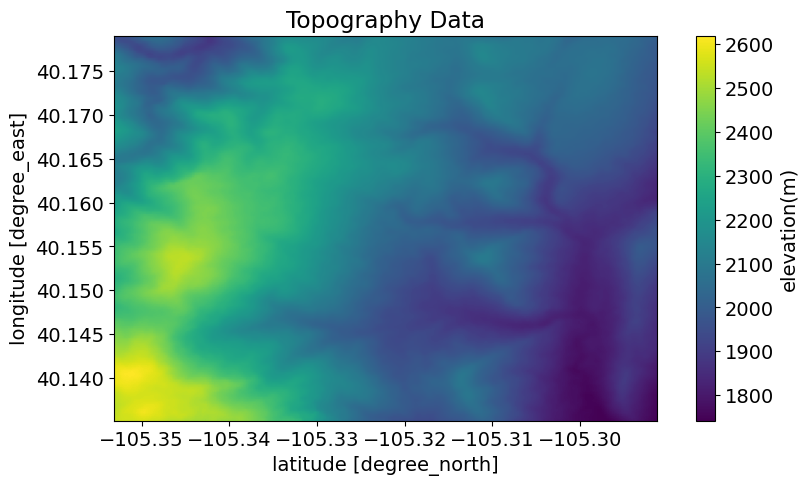

In [9]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
dem_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(dem_data_2D, extent=dem_extent)
ax.title.set_text('Topography Data')
ax.set_xlabel('latitude [degree_north]')
ax.set_ylabel('longitude [degree_east]')
fig.colorbar(im,label='elevation(m)')

<a id='step2'></a>
## Step 2 Delineate Watershed

For our example, we are using the Heil Ranch area comprising Geer Canyon watershed nearby Boulder Colorado, USA. The watershed of Geer Canyon was affected in October 2020 by the Calwood wildfire. 

The Calwood Fire initiated approximate 3 miles North West of Jamestown, in Boulder County, Colorado. It started on a windy day, October 17th, 2020, and ran until contained on November 11th, 2020. The state of Colorado was in drought at the time of occurrence. High winds and dry conditions together caused the fire to spread rapidly, consuming nearly 1000 acres an hour.  This wildfire in total burned ~10,113 acres and destroyed 20 residential homes. It ranged in elevation between ~2500m of the highest terrain to ~1700m. It is the wildfire of the largest extent to occur in Boulder county, but affected less people and structures than the Marshall Fire in 2021.

<img src="https://github.com/gantian127/overlandflow_usecase/blob/master/site.jpeg?raw=true" width="900">

We will use the topography data for watershed delineation. The Landlab components ([FlowAccumulator](https://landlab.readthedocs.io/en/master/reference/components/flow_accum.html) and [ChannelProfiler](https://landlab.readthedocs.io/en/master/reference/components/channel_profiler.html)) and the Landlab utility ([get_watershed_mask](https://landlab.readthedocs.io/en/master/reference/utils/watershed.html)) will be used to accomplish this task. The general steps for watershed delineation include: 
- Setup raster model grid and add topographic elevation data field
- Calculate the flow accumulation
- Get watershed mask
- Set watershed boundary 

Text(0, 0.5, 'north-south distance (m)')

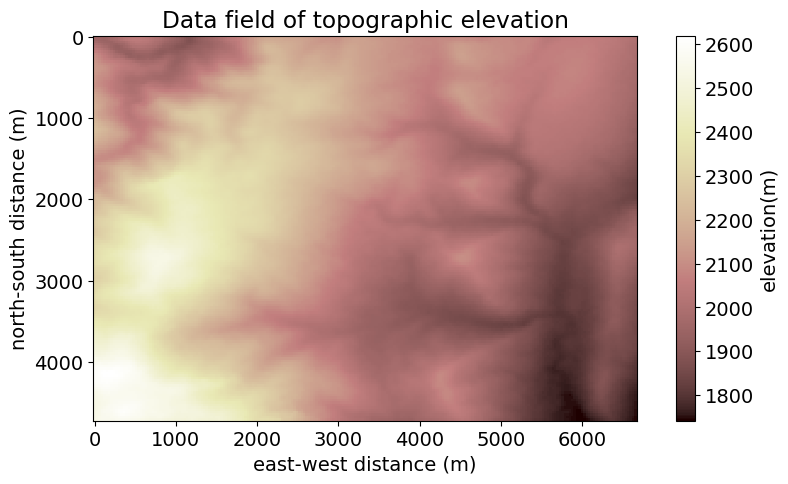

In [10]:
# set up raster model grid  
model_grid = RasterModelGrid(dem_grid_shape, xy_spacing=30)
#model_grid = HexModelGrid(dem_grid_shape, spacing=30, node_layout='rect')

# add topographic elevation data field
dem_field = model_grid.add_field("topographic__elevation", dem_data.astype('float'))

# plot the topographic elevation data field
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid(model_grid,
            'topographic__elevation',
            plot_name='Data field of topographic elevation',
            var_name='elevation(m)')
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')


In [11]:
# calculate the flow accumulation
fa=FlowAccumulator( model_grid, method='Steepest', 
                    flow_director='FlowDirectorSteepest', 
                    depression_finder='LakeMapperBarnes',
                    redirect_flow_steepest_descent=True,
                    reaccumulate_flow=True)
fa.run_one_step()  

Text(0, 0.5, 'north-south distance (m)')

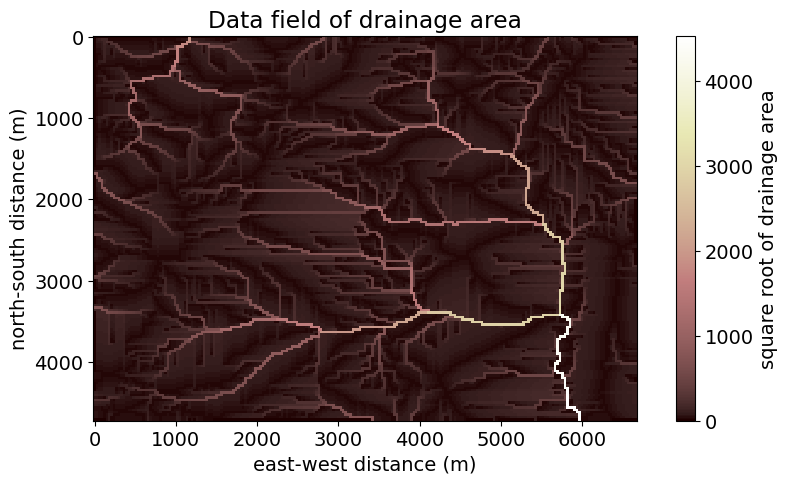

In [12]:
# plot the flow accumulation result
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid(
    model_grid,
    np.sqrt(model_grid.at_node["drainage_area"]),
    plot_name="Data field of drainage area",
    var_name="square root of drainage area",
)
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')

In [13]:
# set up channel profiler 
profiler = ChannelProfiler(model_grid,number_of_watersheds=1)
profiler.run_one_step()

In [14]:
# get watershed mask
outlet = profiler.nodes[0][0]
watershed_mask = get_watershed_mask(model_grid, outlet)

In [15]:
# set watershed boundary
model_grid.at_node["topographic__elevation"][~watershed_mask] = -9999.0
model_grid.status_at_node[~watershed_mask] = model_grid.BC_NODE_IS_CLOSED
model_grid.status_at_node[outlet] = model_grid.BC_NODE_IS_FIXED_VALUE

Text(0, 0.5, 'north-south distance (m)')

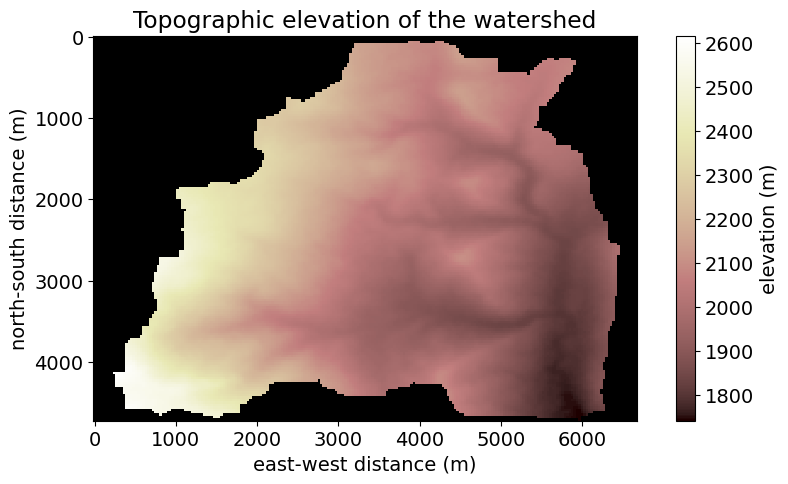

In [16]:
# plot the watershed 
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid_at_node(model_grid, dem_field, 
                    plot_name='Topographic elevation of the watershed',
                    colorbar_label="elevation (m)")

ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')

<a id='step3'></a>
## Step 3  Calculate Overland Flow

In this step, the topography elevation of the watershed and the [Overland Flow component](https://landlab.readthedocs.io/en/master/user_guide/overland_flow_user_guide.html#background-on-overlandflow-component) will be used for the simulation. The model run time is set as 200 min with the first 10 min assigned with a constant rainfall intensity (59.2 mm/hr), which is based on the observation on June 25, 2021 (the summer after the Calwood fire occured). 

In this simulation, we suppose there is no water infiltration process involved. Is this justified? Not really, this is a model simplification for demonstration purposes. But, wildfires cause soils to become extremely dry and  hydrophobic, and decrease infiltration. So this assumption provides an end-member case of extreme soil water repellency affecting the Geer Canyon watershed.

The simulation results will create a discharge time series plot at the outlet and 2D plots of the surface water depth at each 30 sec time step.

Text(0, 0.5, 'north-south distance (m)')

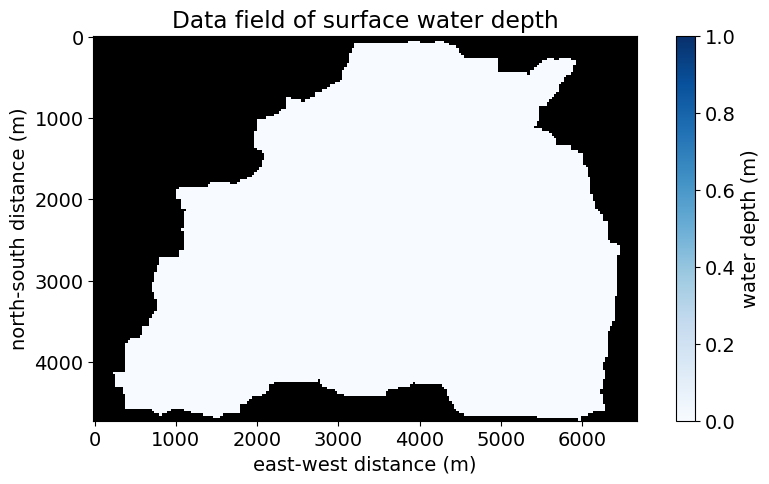

In [17]:
# add surface wate depth data field 
model_grid.add_zeros("surface_water__depth", at="node", clobber=True)

# set initial surface water depth value
model_grid.at_node["surface_water__depth"].fill(
    1e-12
) 

plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid(model_grid,'surface_water__depth', 
            plot_name='Data field of surface water depth',
            var_name='water depth (m)',
            cmap="Blues", vmin=0.0,vmax=1)
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')

<a id='step4'></a>
## Step 4 Visualize Results

Run the cells below and it will show a short video. You will be able to see the changes of the surface water depth over the watershed and the discharge at the outlet over the simulation time. 

You can also reset the value of the "rain_intensity" variable using the ERA5 dataset (see the 3rd cell in [Step3](#step3)). Then rerun Step3 and Step4 to create new results for comparison. 

## References
- Adams, J. M., Gasparini, N. M., Hobley, D. E. J., Tucker, G. E., Hutton, E. W. H., Nudurupati, S. S., and Istanbulluoglu, E.: The Landlab v1.0 OverlandFlow component: a Python tool for computing shallow-water flow across watersheds, Geosci. Model Dev., 10, 1645–1663, https://doi.org/10.5194/gmd-10-1645-2017, 2017.

- Barnhart, K. R., Hutton, E. W. H., Tucker, G. E., M. Gasparini, N., Istanbulluoglu, E., E. J. Hobley, D., J. Lyons, N., Mouchene, M., Siddhartha Nudurupati, S., M. Adams, J., & Bandaragoda, C. (2020). Short communication: Landlab v2.0: A software package for Earth surface dynamics. Earth Surface Dynamics, 8(2), 379–397. https://doi.org/10.5194/esurf-8-379-2020![image.png](attachment:image.png)

- de Almeida, G. A., Bates, P., Freer, J. E., & Souvignet, M. (2012). Improving the stability of a simple formulation of the shallow water equations for 2‐D flood modeling. Water Resources Research, 48(5).

In [26]:
# instantiate overland flow component
overland_flow = OverlandFlow(
    model_grid, steep_slopes=True
)

# set model run parameters
elapsed_time = 0.0
model_run_time = 24 * 3600  # duration of run (s) 
storm_duration = 12 * 3600  # duration of rain (s)  
time_step = 3600 
Melt = np.array([0.000016, 0.000018, 0.000020])

for trial in Melt:
    
    rainfall_intensity = trial
    outlet_discharge = []
    outlet_times = []
    
    # run overland flow simulation
    for time_slice in trange(time_step, model_run_time + time_step, time_step):
    
        while elapsed_time < time_slice:
    
            # get adaptive time step
            overland_flow.dt = min(overland_flow.calc_time_step(), time_slice)

            # set rainfall intensity
            if elapsed_time < (storm_duration):
                overland_flow.rainfall_intensity = rainfall_intensity
            else:
                overland_flow.rainfall_intensity = 0.0
    
            # run model
            overland_flow.overland_flow(dt=overland_flow.dt)
    
            # update elapsed time
            elapsed_time += overland_flow.dt

            # get discharge result
            discharge = overland_flow.discharge_mapper(
                model_grid.at_link["surface_water__discharge"], convert_to_volume=True
            )

            outlet_discharge.append(discharge[outlet])
            outlet_times.append(elapsed_time)

        # plot result
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 9), gridspec_kw={"height_ratios": [1, 1.5]}
        )
        fig.suptitle("Results at {} min".format(time_slice / 60))
    
        ax[0].plot(outlet_times, outlet_discharge, "-")
        ax[0].set_xlabel("Time elapsed (s)")
        ax[0].set_ylabel("discharge (cms)")
        ax[0].set_title("Water discharge at the outlet")

        imshow_grid(
            model_grid,
            "surface_water__depth",
            cmap="Blues",
            vmin=0,
            vmax=1.2,
            var_name="surface water depth (m)",
        )
        ax[1].set_title("")
        ax[1].invert_yaxis()
        ax[1].set_xlabel('east-west distance (m)')
        ax[1].set_ylabel('north-south distance (m)')
        
        #plt.close(fig)
        fig.savefig(os.path.join(results_dir, "{}_flow_{}.png".format(trial, time_slice)))
        plt.clf()
        
    print('Simulation is done')
    
    # Make a short video
    img_files = [os.path.join(results_dir, file) for file in os.listdir(results_dir) if '.png' in file]
    img_files.sort(key=lambda x: os.path.getmtime(x))
    
    with imageio.get_writer(os.path.join(results_dir,'trial_{}.mp4'.format(trial)), mode='I', fps=1,macro_block_size=None ) as writer:
        for f in img_files:
            im = imageio.imread(os.path.join(results_dir, f))
            writer.append_data(im)

    # delete the image files after the video is made, you can either save your images, or make a video!
    for file in img_files:
        os.remove(file)
    
    writer.close()
    
    # reinitiaite the grid
    overland_flow = OverlandFlow(
    model_grid, steep_slopes=True
    )

    # set model run parameters
    elapsed_time = 0.0
    model_run_time = 24 * 3600  # duration of run (s) 
    storm_duration = 12 * 3600  # duration of rain (s)  
    time_step = 3600 

100%|██████████| 24/24 [04:09<00:00, 10.39s/it]
[rawvideo @ 0x562ce5451740] Stream #0: not enough frames to estimate rate; consider increasing probesize


Simulation is done


100%|██████████| 100/100 [00:42<00:00,  2.37it/s]
[rawvideo @ 0x5599355e7740] Stream #0: not enough frames to estimate rate; consider increasing probesize


Simulation is done


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]
[rawvideo @ 0x556427cd5740] Stream #0: not enough frames to estimate rate; consider increasing probesize


Simulation is done


<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

<Figure size 800x900 with 0 Axes>

In [27]:
Video("./results_calwood/trial_1.6e-05.mp4", width=900, height=700)

In [28]:
Video("./results_calwood/trial_1.8e-05.mp4", width=900, height=700)

In [29]:
Video("./results_calwood/trial_2e-05.mp4", width=900, height=700)

In [23]:
Video("./results_calwood/trial_1.25e-05.mp4", width=900, height=700)

In [25]:
Video("./results_calwood/trial_2.85e-05.mp4", width=900, height=700)